## 网络结构的可视化

In [ ]:
基于Pytorch的相关可视化工具

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
from torch.optim import SGD
import torch.utils.data as Data
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ImportError: dlopen(/Users/yemeng/opt/miniforge3/envs/py38dl/lib/python3.9/site-packages/scipy/spatial/_qhull.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: /Users/yemeng/opt/miniforge3/envs/py38dl/lib/python3.9/site-packages/scipy/spatial/_qhull.cpython-39-darwin.so
  Reason: tried: '/Users/yemeng/opt/miniforge3/envs/py38dl/lib/python3.9/site-packages/scipy/spatial/../../../../liblapack.3.dylib' (no such file), '/Users/yemeng/opt/miniforge3/envs/py38dl/lib/python3.9/site-packages/scipy/spatial/../../../../liblapack.3.dylib' (no such file), '/Users/yemeng/opt/miniforge3/envs/py38dl/lib/liblapack.3.dylib' (no such file), '/Users/yemeng/opt/miniforge3/envs/py38dl/bin/../lib/liblapack.3.dylib' (no such file), '/Users/yemeng/opt/miniforge3/envs/py38dl/lib/liblapack.3.dylib' (no such file), '/Users/yemeng/opt/miniforge3/envs/py38dl/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)

In [ ]:
## 使用手写字体数据
## 准备训练数据集
train_data  = torchvision.datasets.MNIST(
    root = "./data/MNIST", # 数据的路径
    train = True, # 只使用训练数据集
    # 将数据转化为torch使用的张量,取值范围为［0，1］
    transform  = torchvision.transforms.ToTensor(),
    download= False # 因为数据已经下载过，所以这里不再下载
)
## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=128, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 2, # 使用两个进程 
)

In [ ]:
##  获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸
print(b_x.shape)
print(b_y.shape)

In [6]:
## 准备需要使用的测试数据集
test_data  = torchvision.datasets.MNIST(
    root = "./data/MNIST", # 数据的路径
    train = False, # 不使用训练数据集
    download= False # 因为数据已经下载过，所以这里不再下载
)
## 为数据添加一个通道纬度,并且取值范围缩放到0～1之间
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x,dim = 1)
test_data_y = test_data.targets  ## 测试集的标签

print("test_data_x.shape:",test_data_x.shape)
print("test_data_y.shape:",test_data_y.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])
test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


In [7]:
## 搭建一个卷积神经网络
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        ## 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,## 输入的feature map
                out_channels = 16, ## 输出的feature map
                kernel_size = 3, ##卷积核尺寸
                stride=1,   ##卷积核步长
                padding=1, # 进行填充
            ), 
            nn.ReLU(),  # 激活函数
            nn.AvgPool2d(
                kernel_size = 2,## 平均值池化层,使用 2*2
                stride=2,   ## 池化步长为2 
            ), 
        )
        ## 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,1), 
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(2,2) ## 最大值池化
        )
        ## 定义全连接层
        self.fc = nn.Sequential(
            nn.Linear(
                in_features = 32*7*7, ## 输入特征
                out_features = 128, ## 输出特证数
            ),
            nn.ReLU(),  # 激活函数
            nn.Linear(128,64),
            nn.ReLU()  # 激活函数
        )
        self.out = nn.Linear(64,10) ## 最后的分类层


    ## 定义网络的向前传播路径   
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展平多维的卷积图层
        x = self.fc(x)
        output = self.out(x)
        return output
    
## 输出我们的网络结构
MyConvnet = ConvNet()
print(MyConvnet)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)


###  使用hiddenlayer包可视化网络

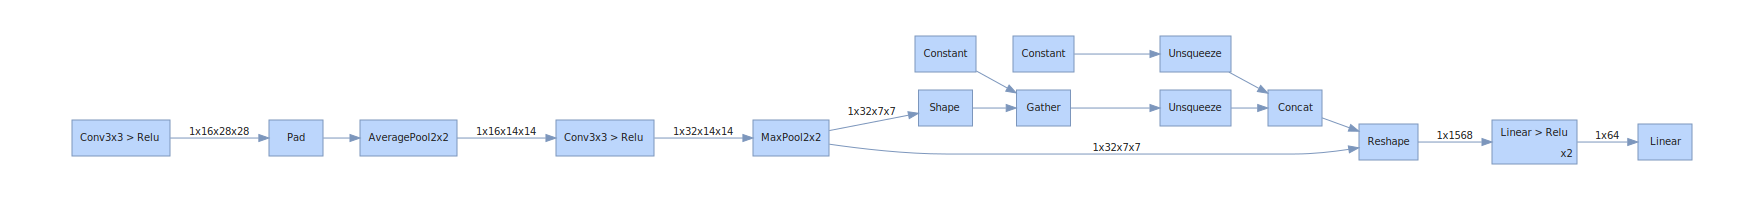

In [9]:
import hiddenlayer as hl
## 可视化卷积神经网络
hl_graph = hl.build_graph(MyConvnet, torch.zeros([1, 1, 28, 28]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()  
hl_graph

In [5]:
## 将可视化的网路保存为图片,默认格式为pdf
hl_graph.save("data/chap4/MyConvnet_hl.png", format="png")

###  使用torchviz包可视化网络

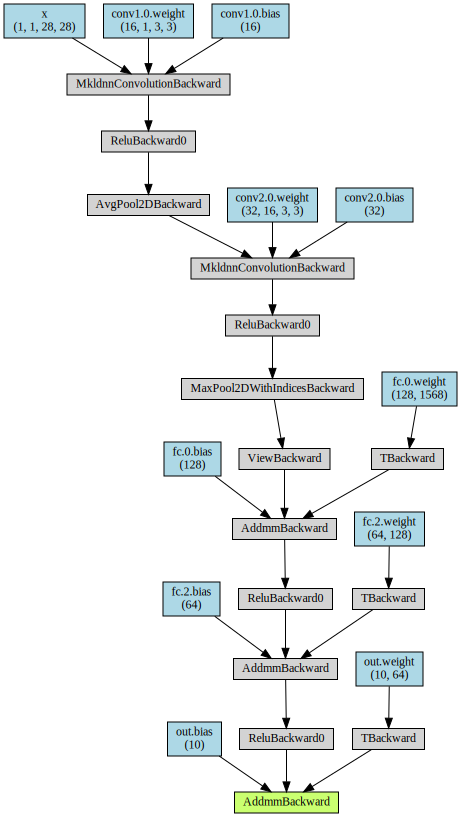

In [11]:
from torchviz import make_dot
## 使用make_dot可视化网络
x = torch.randn(1, 1, 28, 28).requires_grad_(True)
y = MyConvnet(x)
MyConvnetvis = make_dot(y, params=dict(list(MyConvnet.named_parameters()) + [('x', x)]))
MyConvnetvis

In [9]:
## 将mlpvis保存为图片
MyConvnetvis.format = "png" ## 形式转化为png,默认pdf
## 指定文件保存位置
MyConvnetvis.directory = "data/chap4/MyConvnet_vis"
MyConvnetvis.view() ## 会自动在当前文件夹生成文件

'data/chap4/MyConvnet_vis/Digraph.gv.png'

## 训练过程的可视化

### 利用tensorboardX

In [13]:
## 从tensorboardX库中导入需要的API
from tensorboardX import SummaryWriter
SumWriter = SummaryWriter(log_dir="data/chap4/log")

In [12]:
# 定义优化器
optimizer = torch.optim.Adam(MyConvnet.parameters(), lr=0.0003)  
loss_func = nn.CrossEntropyLoss()   # 损失函数
train_loss = 0
print_step = 100 ## 每经过100次迭代后,输出损失
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(5):
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):  
        ## 计算每个batch的
        output = MyConvnet(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 交叉熵损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss = train_loss+loss    # 计算损失的累加损失
        ## 计算迭代次数
        niter = epoch * len(train_loader) + step+1
        ## 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            ## 为日志添加训练集损失函数
            SumWriter.add_scalar("train loss",
                                 train_loss.item() / niter,
                                 global_step=niter)
            ## 计算在测试集上的精度
            output = MyConvnet(test_data_x)
            _,pre_lab = torch.max(output,1)
            acc = accuracy_score(test_data_y,pre_lab)
            ## 为日志添加在测试集上的预测精度
            SumWriter.add_scalar("test acc",acc.item(),niter)
            ## 为日志中添加训练数据的可视化图像，使用当前batch的图像
            ## 将一个batch的数据进行预处理
            b_x_im = vutils.make_grid(b_x,nrow=12)
            SumWriter.add_image('train image sample', b_x_im,niter)
            ## 使用直方图可视化网络中参数的分布情况
            for name, param in MyConvnet.named_parameters():
                SumWriter.add_histogram(name, param.data.numpy(),niter)
       

In [10]:
# ## 为日志中添加训练数据的可视化图像，使用最后一个batch的图像
# ## 将一个batch的数据进行预处理
# b_x_im = vutils.make_grid(b_x,nrow=12)
# SumWriter.add_image('train image sample', b_x_im)

In [11]:
# ## 使用直方图可视化网络中参数的分布情况
# for name, param in MyConvnet.named_parameters():
#     SumWriter.add_histogram(name, param.data.numpy())

### 利用hiddenlayer


In [13]:
import hiddenlayer as hl
import time

In [14]:
## 初始化MyConvnet
MyConvnet = ConvNet()
print(MyConvnet)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)


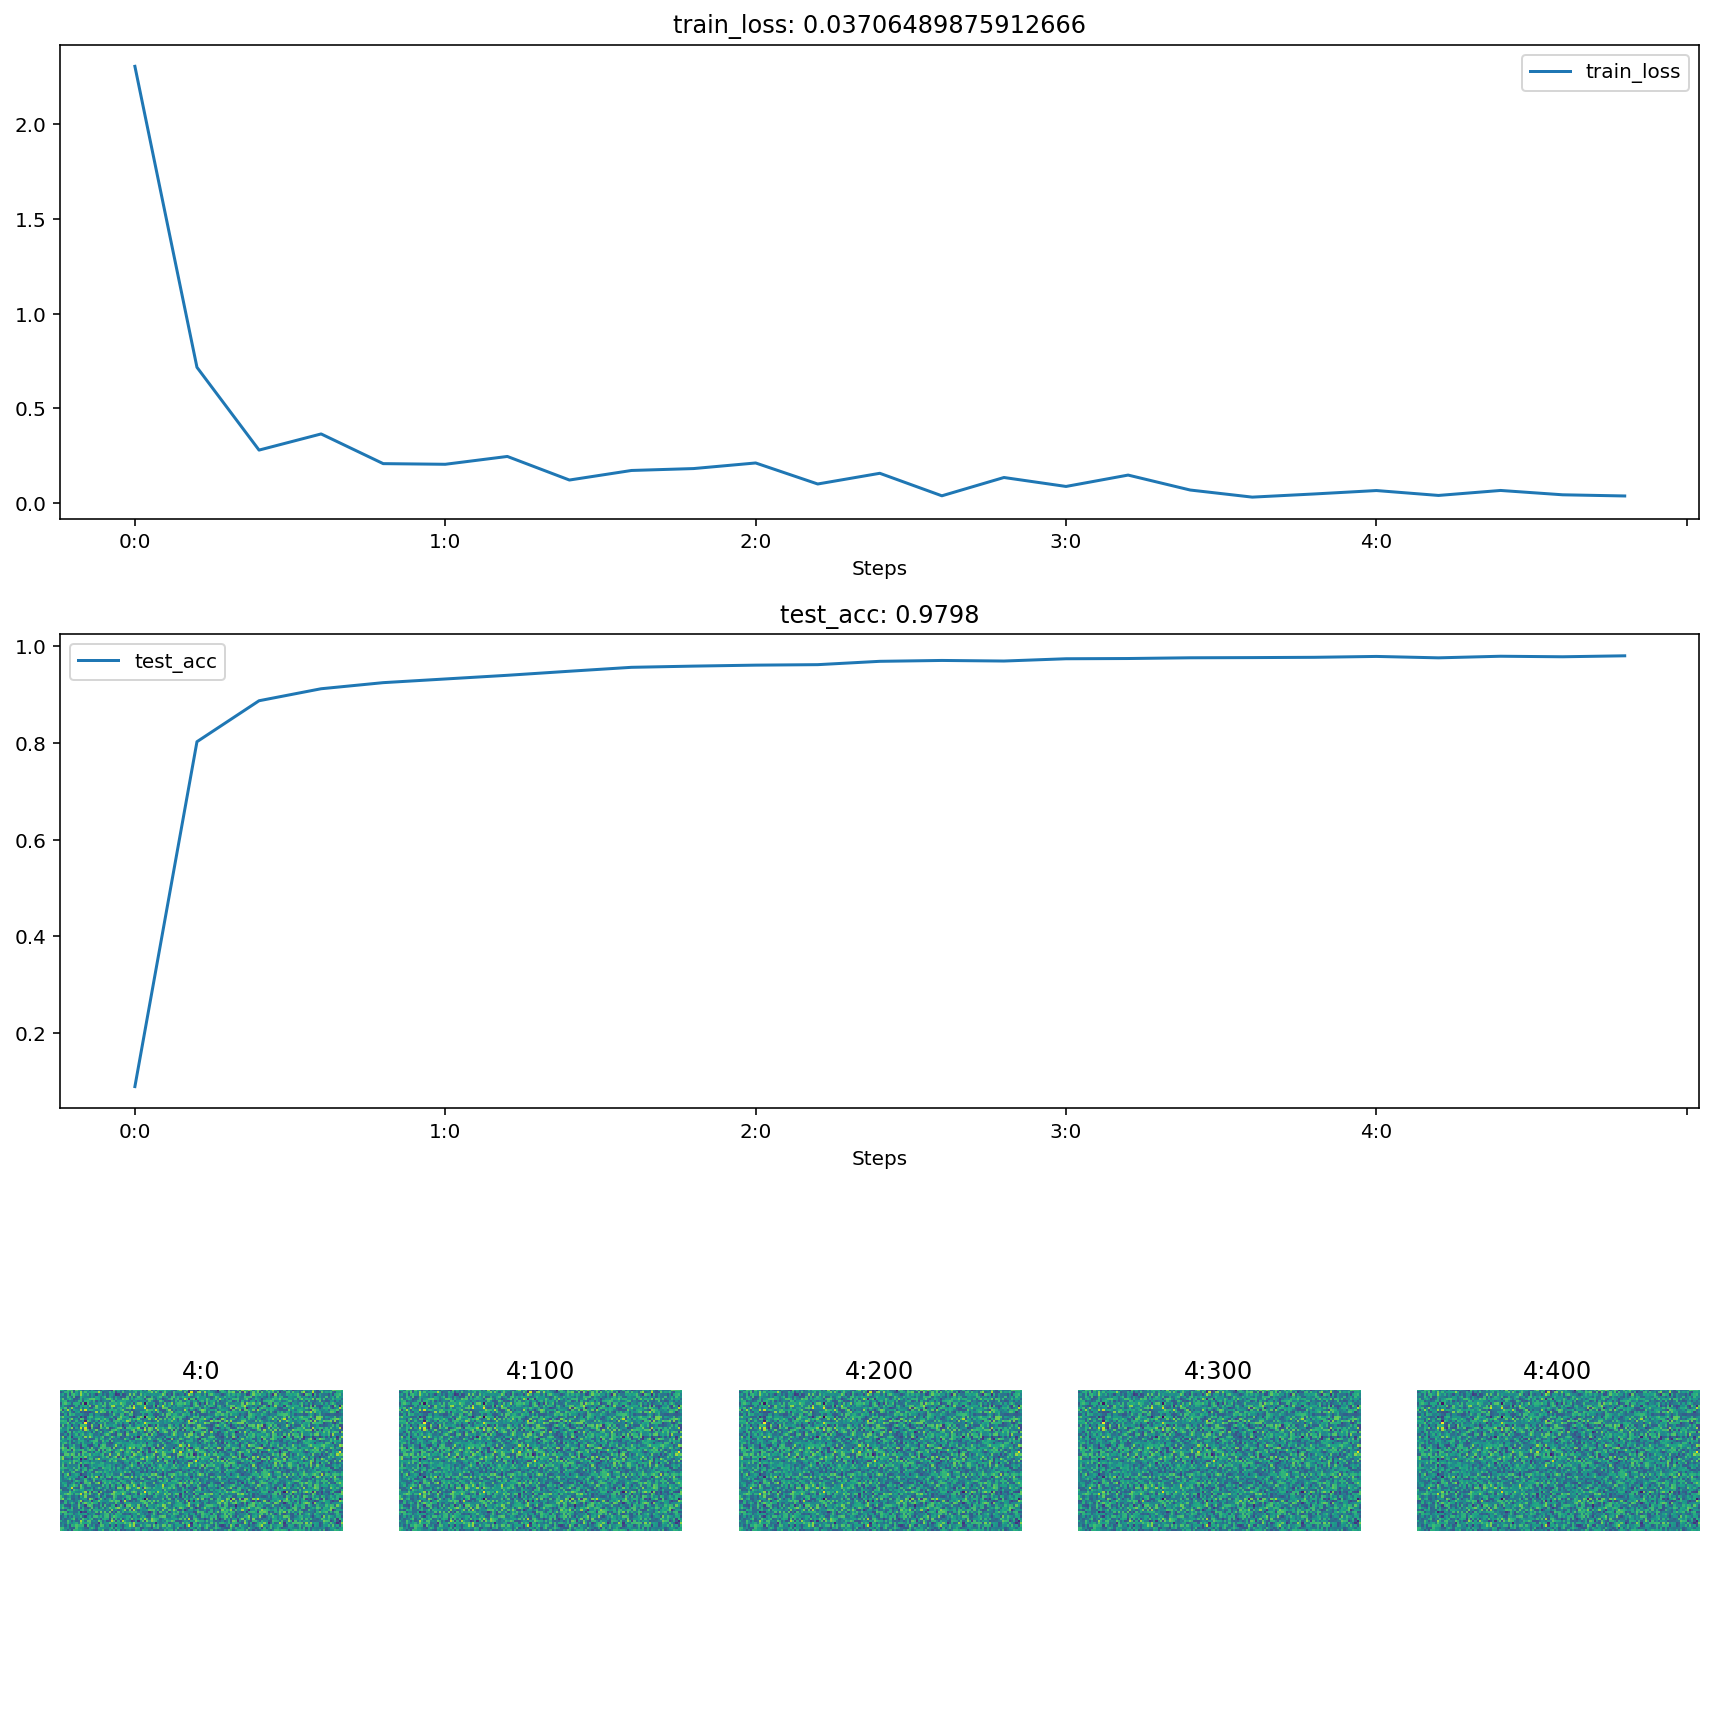

In [15]:
# 定义优化器
optimizer = torch.optim.Adam(MyConvnet.parameters(), lr=0.0003)  
loss_func = nn.CrossEntropyLoss()   # 损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 100 ## 每经过100次迭代后,输出损失
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(5):
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):  
        ## 计算每个batch的
        output = MyConvnet(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 交叉熵损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        ## 计算迭代次数
        ## 计算每经过print_step次迭代后的输出
        if step % print_step == 0:
            ## 计算在测试集上的精度
            output = MyConvnet(test_data_x)
            _,pre_lab = torch.max(output,1)
            acc = accuracy_score(test_data_y,pre_lab)
            ## 计算每个epoch和step的模型的输出特征
            history1.log((epoch, step),
                         train_loss=loss,# 训练集损失
                         test_acc = acc, # 测试集精度
                         ## 第二个全连接层权重
                         hidden_weight=MyConvnet.fc[2].weight)
            # 可视网络训练的过程
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_acc"])
                canvas1.draw_image(history1["hidden_weight"])
       

## 使用Visdom进行可视化

In [15]:
from visdom import Visdom

### 可视化numpy类型的数据

In [7]:
from sklearn.datasets import load_iris
iris_x,iris_y = load_iris(return_X_y=True)
print(iris_x.shape)
print(iris_y.shape)

(150, 4)
(150,)


In [8]:
## 2D散点图
vis = Visdom()
vis.scatter(iris_x[:,0:2],Y = iris_y+1,win="windows1",env="main")

Setting up a new session...


'windows1'

In [9]:
## 3D散点图
vis.scatter(iris_x[:,0:3],Y = iris_y+1,win="3D 散点图",env="main",
            opts = dict(markersize = 4,# 点的大小
                        xlabel = "特征1",ylabel = "特征2") 
           )

'3D 散点图'

In [10]:
## 添加折线图
x = torch.linspace(-6,6,100).view((-1,1))
sigmoid = torch.nn.Sigmoid()
sigmoidy = sigmoid(x)
tanh = torch.nn.Tanh()
tanhy = tanh(x)
relu = torch.nn.ReLU()
reluy = relu(x)
## 连接3个张量
ploty = torch.cat((sigmoidy,tanhy,reluy),dim=1)
plotx = torch.cat((x,x,x),dim=1)
vis.line(Y=ploty,X=plotx,win="line plot",env="main",
         ##  设置线条的其它属性
         opts = dict(dash = np.array(["solid","dash","dashdot"]),
                     legend = ["Sigmoid","Tanh","ReLU"]))

'line plot'

In [11]:
## 添加
x = torch.linspace(-6,6,100).view((-1,1))
y1 = torch.sin(x)
y2 = torch.cos(x)
## 连接2个张量
plotx = torch.cat((y1,y2),dim=1)
ploty = torch.cat((x,x),dim=1)
vis.stem(X=plotx,Y=ploty,win="stem plot",env="main",
         ##  设置图例
         opts = dict(legend = ["sin","cos"],
                     title = "茎叶图"))


'stem plot'

In [12]:
## 添加热力图
# 计算鸢尾花数据的相关系数
iris_corr = torch.from_numpy(np.corrcoef(iris_x,rowvar=False))
vis.heatmap(iris_corr,win="heatmap",env="main",
            ## 设置每个特征的名称
            opts=dict(rownames = ["x1","x2","x3","x4"],
                     columnnames =["x1","x2","x3","x4"],
                     title = "热力图"))

'heatmap'

In [13]:
## 创建新的可视化图像环境，可视化图像
##  获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸
print(b_x.shape)
print(b_y.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128])


In [14]:
## 可视化其中的一张图片
vis.image(b_x[0,:,:,:],win="one image", env="MyimagePlot",
          opts = dict(title = "一张图像"))

'one image'

In [15]:
## 它形成一个大小（B / nrow，nrow）的图像网格
vis.images(b_x,win="my batch image", env="MyimagePlot",
           nrow = 16,opts = dict(title = "一个批次的图像"))

'my batch image'

In [16]:
## 可视化一段文本
texts = """A flexible tool for creating, organizing, 
and sharing visualizations of live,rich data.
Supports Torch and Numpy."""
vis.text(texts,win="text plot", env="MyimagePlot",
         opts = dict(title = "可视化文本"))

'text plot'